In [1]:
!pip install mnist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!tar -xf "/content/drive/My Drive/imimic/wann/cnn_weights.tar.xz" weights-72-0.9744-0.9918.hdf5

In [0]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import mnist
random.seed(1)
np.random.seed(1)

In [5]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = mnist.train_images()
y_train = mnist.train_labels()
x_test = mnist.test_images()
y_test = mnist.test_labels()

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.load_weights('weights-72-0.9744-0.9918.hdf5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
import os
import numpy as np
from skimage.transform import resize

MASK_PATH = os.path.join('rise_masks.npy')
MASK_COUNT = 5000
s = 8
p1 = 0.5

def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks


def explain(model, inp, masks, input_size):
    batch_size = 100
    preds = []
    # Make sure multiplication is being done for correct axes

    for i in range(0, MASK_COUNT, batch_size):
        #print(i, MASK_COUNT)
        sub_masks = masks[i:min(i + batch_size, MASK_COUNT)]
        masked = inp * sub_masks
        preds.append(model.predict(masked))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(MASK_COUNT, -1)).reshape(-1, *input_size)
    sal = sal / MASK_COUNT / p1
    return sal

masks = generate_masks(MASK_COUNT, s, p1, (28, 28))

label: 6
prediction 6
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000
Prediction label changed
count 79
prediction 5
0.00000, 0.00000, 0.00000, 0.00000, 0.00033, 0.99951, 0.00016, 0.00000, 0.00000, 0.00000


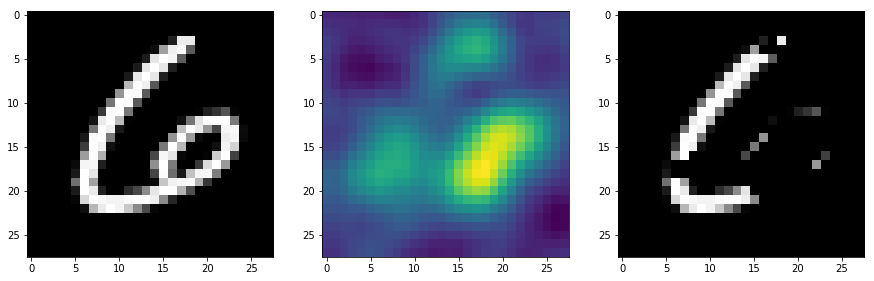

--------------------------------------------------------------------------------
label: 9
prediction 9
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000
Prediction label changed
count 30
prediction 4
0.00000, 0.00000, 0.00000, 0.00000, 0.84354, 0.00000, 0.00000, 0.00000, 0.00000, 0.15646


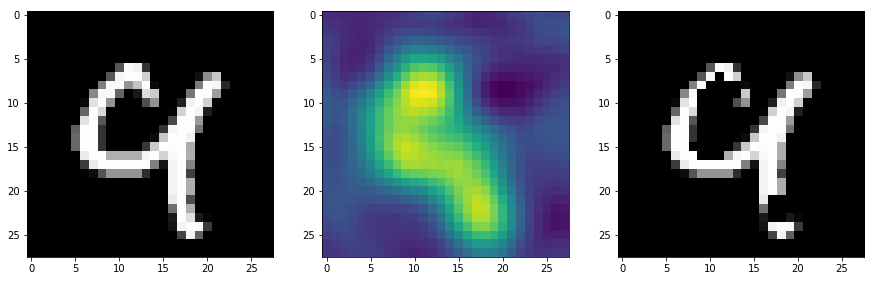

--------------------------------------------------------------------------------
label: 2
prediction 2
0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000
Prediction confidence below 0.8
count 65
prediction 2
0.00000, 0.00000, 0.70620, 0.29380, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000


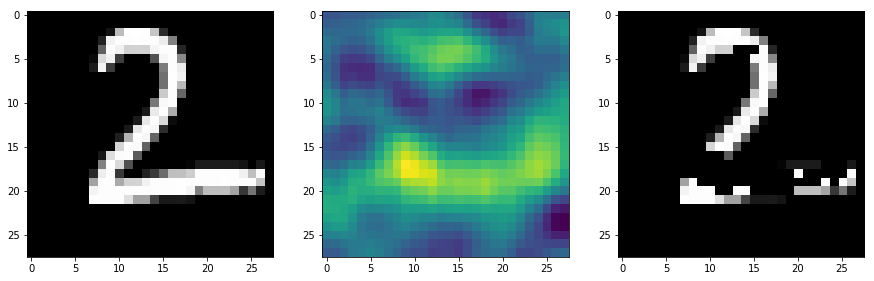

--------------------------------------------------------------------------------
label: 6
prediction 6
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000, 0.00000
Prediction label changed
count 75
prediction 4
0.00000, 0.00011, 0.02093, 0.00000, 0.75332, 0.00000, 0.22564, 0.00000, 0.00000, 0.00000


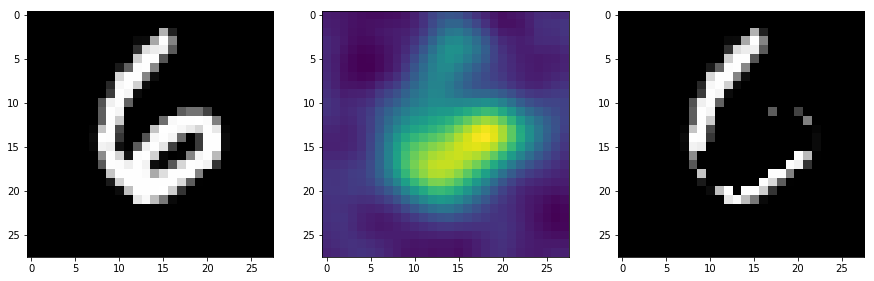

--------------------------------------------------------------------------------
label: 7
prediction 7
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000
Prediction confidence below 0.8
count 61
prediction 7
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.46334, 0.00000, 0.53590, 0.00000, 0.00076


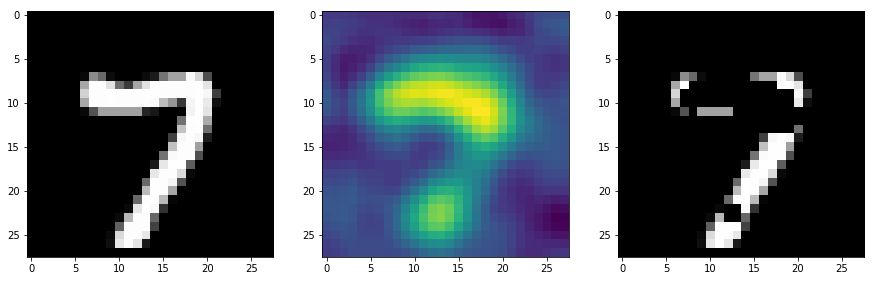

--------------------------------------------------------------------------------
label: 6
prediction 6
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.99999, 0.00000, 0.00001, 0.00000
Prediction confidence below 0.8
count 50
prediction 6
0.00000, 0.00000, 0.00000, 0.00000, 0.38111, 0.00001, 0.57550, 0.00000, 0.04337, 0.00000


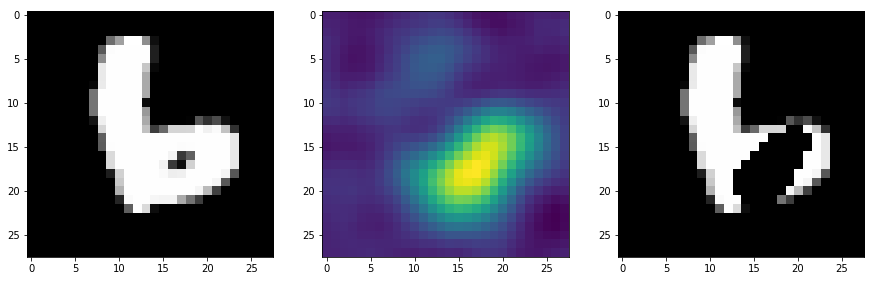

--------------------------------------------------------------------------------
label: 1
prediction 1
0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000
Classification result unchanged after modification
count 199
prediction 1
0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000


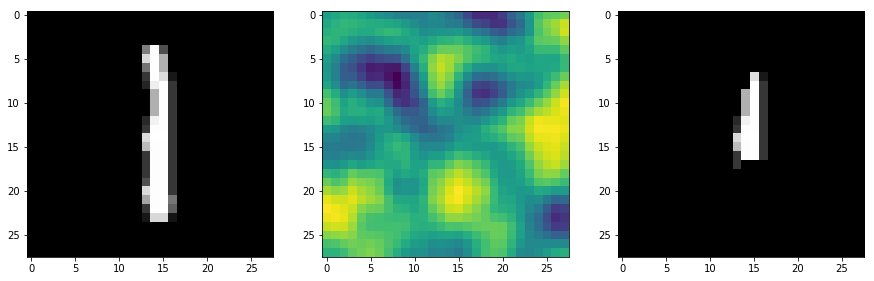

--------------------------------------------------------------------------------
label: 4
prediction 4
0.00000, 0.00000, 0.00000, 0.00000, 0.99999, 0.00000, 0.00000, 0.00000, 0.00000, 0.00001
Prediction confidence below 0.8
count 57
prediction 4
0.00000, 0.00000, 0.10027, 0.00000, 0.76202, 0.00000, 0.00000, 0.04790, 0.00000, 0.08981


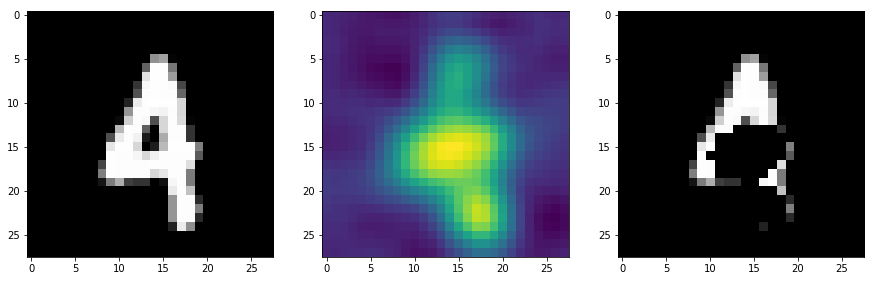

--------------------------------------------------------------------------------
label: 7
prediction 7
0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000, 0.00000
Prediction label changed
count 177
prediction 1
0.00000, 0.85714, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.14286, 0.00000, 0.00000


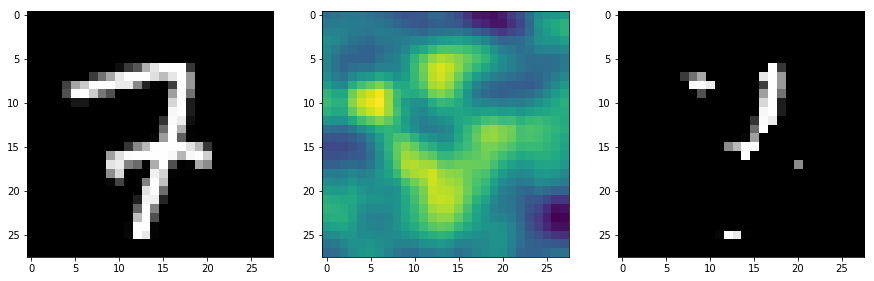

--------------------------------------------------------------------------------
label: 1
prediction 1
0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000
Classification result unchanged after modification
count 199
prediction 1
0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000


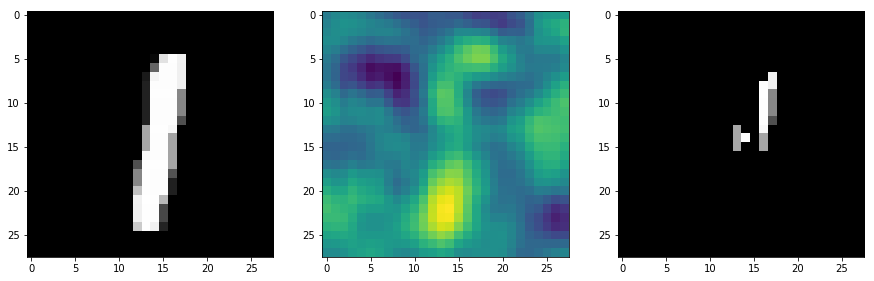

--------------------------------------------------------------------------------


In [13]:
def evaluate(index):
  image = x_test[index]

  label = np.argmax(y_test[index])
  print('label:', label)

  baseline = model.predict(image.reshape(1, 28, 28, 1))
  predicted_label = np.argmax(baseline[0])

  print('prediction', predicted_label)
  print(', '.join([f'{x:.5f}' for x in baseline[0]]))

  sal = explain(model, image, masks, (28, 28))
  
  if predicted_label != label:
    print('Network did not recognize unchanged image, skipping')
    return

  flat = sal[label].reshape(28*28)

  for count in range(1, 200):
    highest_indexes = np.argpartition(flat, -count)[-count:]

    modified_img = np.copy(image.reshape(28 * 28))
    modified_img[highest_indexes] = 0
    new_prediction = model.predict(modified_img.reshape(1, 28, 28, 1))
    new_prediction_label = np.argmax(new_prediction[0])
    new_prediction_value = np.max(new_prediction[0])
    #print('count', count)
    #print('prediction', new_prediction_label)
    #print(', '.join([f'{x:.5f}' for x in new_prediction[0]]))
 
    if new_prediction_label != label:
      print('Prediction label changed')
      break
    if new_prediction_value < 0.8:
      print('Prediction confidence below 0.8')
      break
  else:
    print('Classification result unchanged after modification')

  print('count', count)
  print('prediction', new_prediction_label)
  print(', '.join([f'{x:.5f}' for x in new_prediction[0]]))
  figure, plots = plt.subplots(1, 3, figsize=(15, 5))
  plots[0].imshow(image.reshape(28, 28), cmap='Greys_r')
  plots[1].imshow(sal[label])
  plots[2].imshow(modified_img.reshape(28, 28), cmap='Greys_r')
  plt.show()
  
  print('-' * 80)

  
for index in [9953, 3850, 4962, 3886, 5437, 8517, 2041, 1989, 1933, 9984]:
    evaluate(index)